In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [127]:
session_info = {'date': "18_09_2024",
                'genotype_dir': 'R56H10_GRABOA',
                'fly': 'fly1',
                'session': 'closed_loop-002',
                'full_genotype': '+/-; +/UAS-GRABDA2m; R54E12-Gal4/+',
                'ecl date': '9/11/2023',
                'fictrac_scan_num':0,
                'fictrac_dat_file' : "fictrac-20240913_115137.dat",
                'notes':''}

session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])

In [80]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
pp.align_fictrac()
# nap = pp.open_napari()

MetadataError: metadata file /media/mplitt/SSD_storage/2PData/R54E12_GRABDA2m/12_09_2024/fly3/closed_loop-0001/closed_loop-0001.xml does not exist

In [4]:
nap = pp.open_napari(check_for_existing=False)

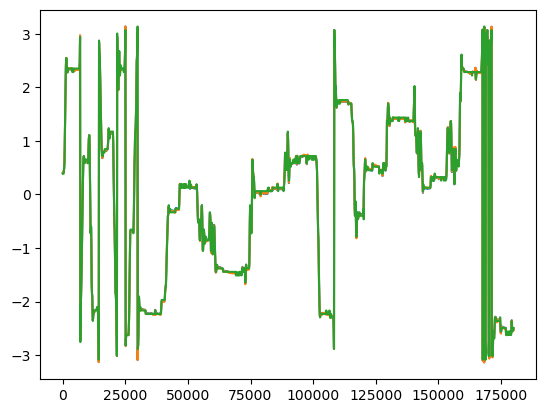

In [5]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
# ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [6]:
print('next')

next


In [7]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [8]:
# y = pp.timeseries['rois'] - pp.timeseries['background']
# y = y-y.mean(axis=1,keepdims=True)
# y = sp.stats.zscore(y, axis=-1)
y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)


In [9]:
pp.save()

In [128]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    # pp.extract_timeseries(max_proj=False)
    y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=True)

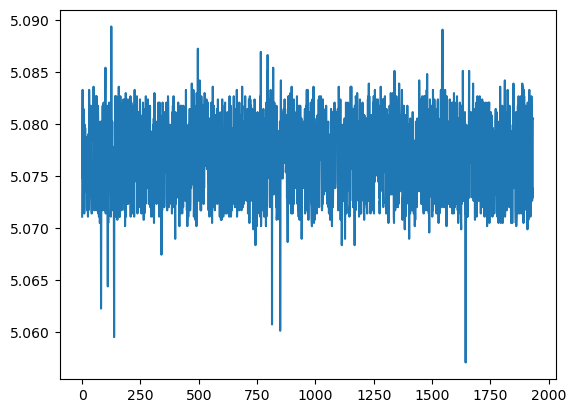

In [129]:
fig, ax = plt.subplots()
ax.plot(pp.voltage_recording_aligned[' Arena DAC2'])

In [130]:
pp.timeseries['background'][0,:,:]

array([[8.55521922, 9.72458821, 8.93743056, ..., 7.90843222, 6.8589853 ,
        7.72626274]])

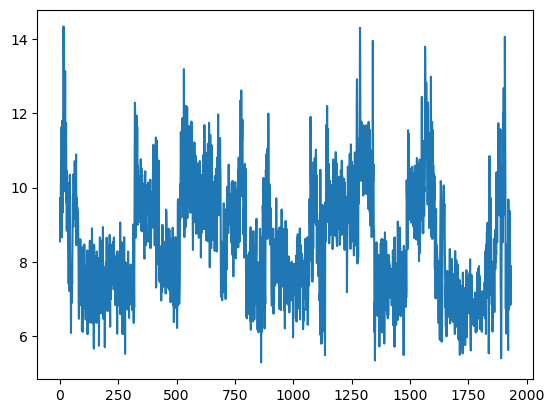

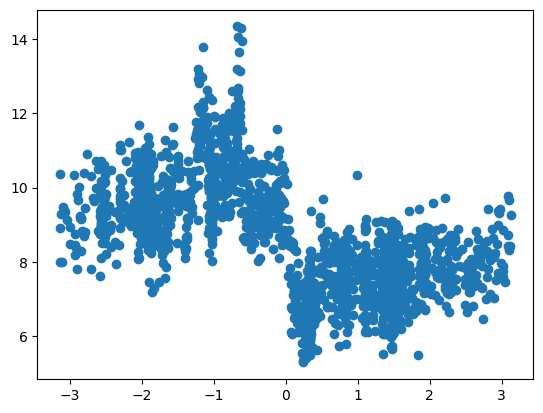

In [131]:
fig,ax = plt.subplots()
ax.plot(pp.timeseries['background'][-1,:,:].ravel())

fig, ax = plt.subplots()
heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
ax.scatter(-1*pp.voltage_recording_aligned[' Heading'].to_numpy(), pp.timeseries['background'][-1,:,:])
mask = (np.abs(heading)> .5) * (pp.voltage_recording_aligned[' Arena DAC2']<7) 

In [132]:

y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y, .7, axis=1,mode='wrap'),2,axis=-1)
# y_sm = sp.ndimage.gaussian_filter1d(y-1, 2, axis=-1)
# y_sm = sp.ndimage.gaussian_filter1d(y-y.mean(axis=1,keepdims=True), 2, axis=-1)
# y_sm = y-1

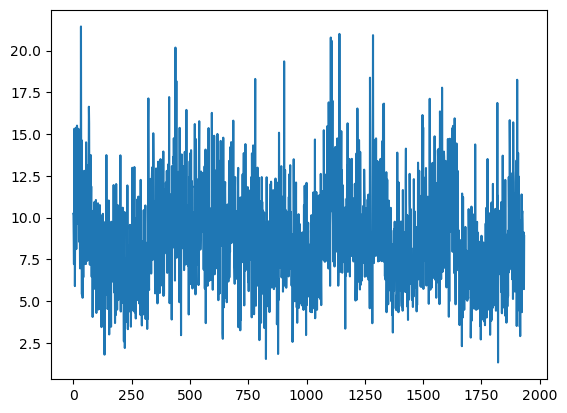

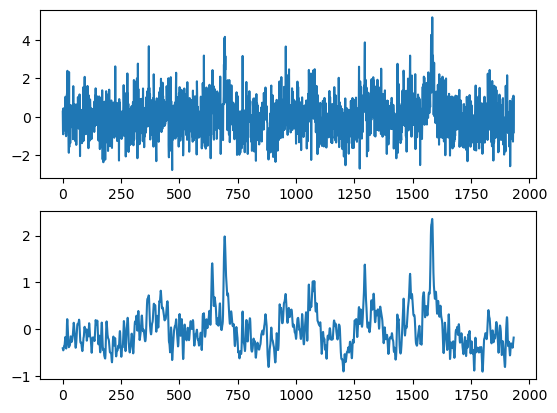

In [133]:
fig,ax = plt.subplots()
# ax.imshow(pp.timeseries['rois'][1,:,:],aspect='auto')
ax.plot(pp.timeseries['rois'][-1,1,:])
fig, ax = plt.subplots(2,1)
ax[0].plot(y[-1,8,:])
ax[1].plot(y_sm[-1,8,:])


In [134]:
x_f,y_f = st2p.utilities.pol2cart(y_sm[-1,:,:]-y_sm[-1,:,:].mean(axis=0,keepdims=True) ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(1934,) (1934,)


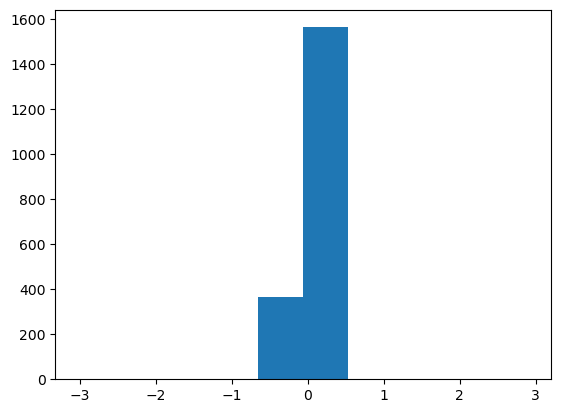

In [135]:
dh = np.ediff1d(heading, to_end=0)
_, dh = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones_like(heading), dh))
# dh[:-1] = np.angle(np.exp(1j*heading[1:])*np.exp(1j*heading[:-1]))
fig, ax = plt.subplots()
ax.hist(dh)
rot_mask = np.abs(dh)>np.pi/32
# print(np.pi/16)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 1934) (1934,)
0.8754769869383979


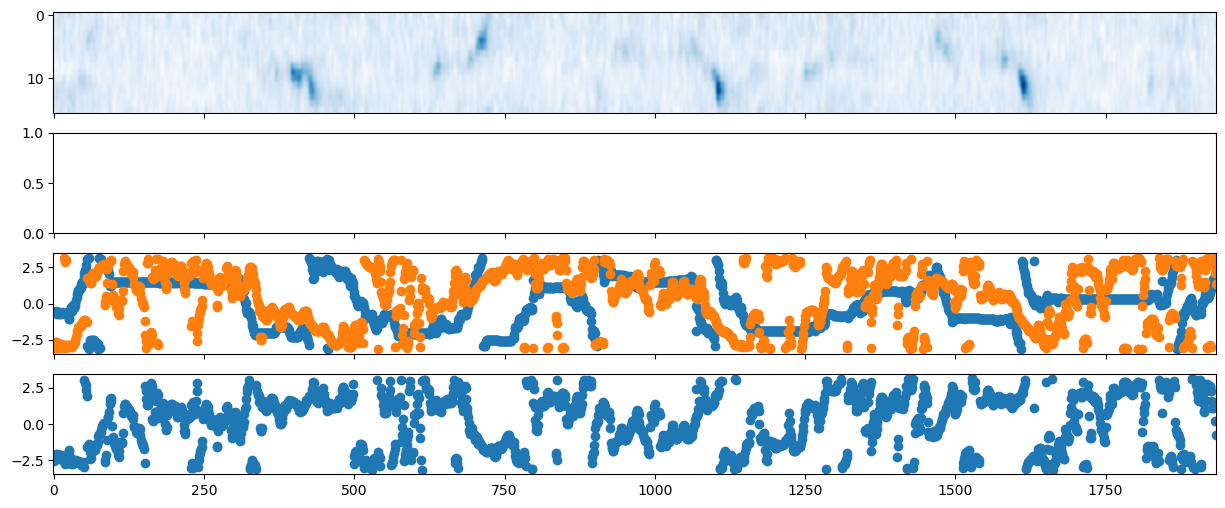

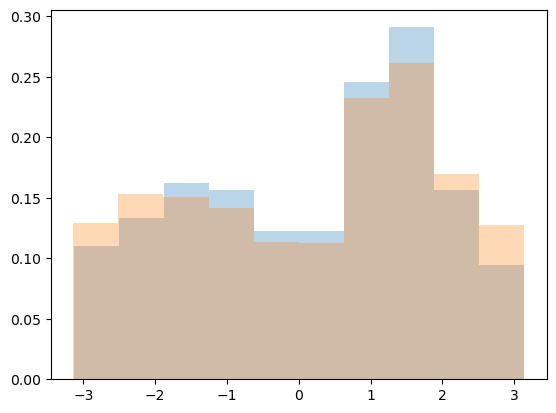

In [136]:
fig, ax= plt.subplots(4,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues')#, vmin=-.2, vmax=.2)
# ax[1].imshow(y_sm[-1,::-1,:]-y_sm[0,:,:].mean(axis=0,keepdims=True), aspect='auto', cmap= 'Blues') #, vmin=-2, vmax=2)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[2].scatter(x,heading)
ax[2].scatter(x, phi)
ax[3].scatter(x, offset)

# mask = np.abs(heading)> 1.5
fig, ax= plt.subplots()
ax.hist(offset[mask], density=True, alpha = .3)
ax.hist(offset,density=True, alpha=.3) 

print(sp.stats.circvar(offset))

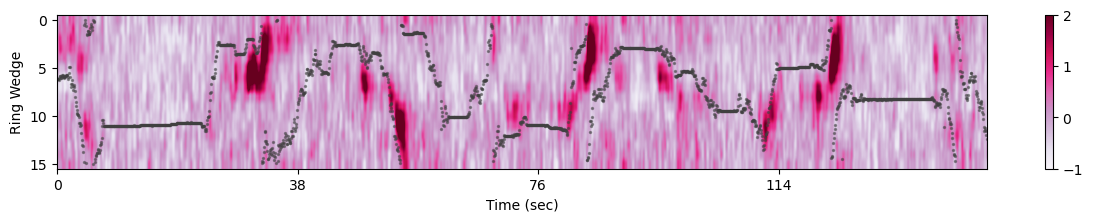

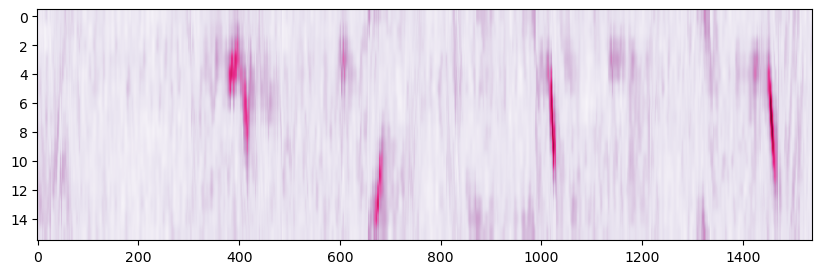

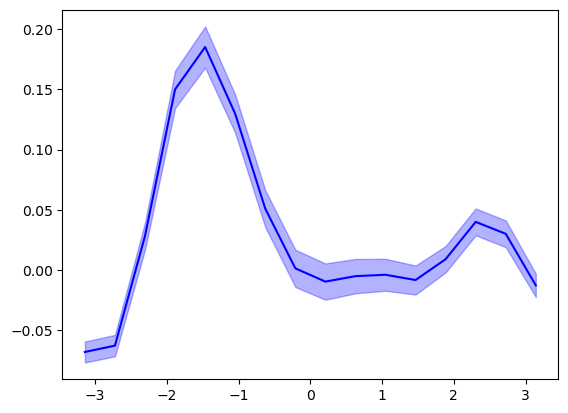

In [137]:
dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
x = np.arange(heading.shape[0])
t = np.arange(0,x[-1]*dt,dt)    

heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[-1,:,ind] = np.roll(y_sm[-1,:,ind], -heading_ind[ind])


fig, ax= plt.subplots(1,1, figsize=[15,2])

h=ax.imshow(y_sm[-1,:, :], cmap='PuRd',aspect='auto', vmin = -1, vmax=2)
ax.scatter(x, 15*(heading+np.pi)/2/np.pi, color=plt.cm.Greys(.8), alpha = .5, s=2)

ax.set_xticks(x[::500],labels=[int(_t) for _t in t[::500]])
ax.set_xlabel('Time (sec)')

ax.set_ylabel('Ring Wedge')
fig.colorbar(h)
fig.savefig('/media/mplitt/SSD_storage/fig_scratch/GRABOA_example3.pdf')

# ax[1].imshow(y_sm_heading_aligned[-1,:,:], cmap='PuRd',aspect='auto') #, vmin = -.2, vmax=.2)



fill = np.ones_like(y_sm[-1,:,:])
fill[:, mask]=np.nan
# ax[0].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.4)
# ax[1].imshow(fill, aspect='auto', cmap='gray', vmax=1, vmin=0, alpha=.4)
                   

# y_sm_ha = y
mask_pre = 1*mask
# mask_pre[:1000]=0
# mask_pre[150:]=0
mask_pre = mask_pre>0

# print(mu.shape, sem.shape)
fig, ax = plt.subplots(figsize=[10,3])
ax.imshow(y_sm_heading_aligned[-1,:,mask_pre].T, cmap='PuRd', aspect='auto')#, vmin=-.2, vmax=.2)

fig, ax= plt.subplots()
mu = y_sm_heading_aligned[:,:,mask_pre].mean(axis=-1)[-1,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask_pre], axis=-1)[-1,:]
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')
# ax.set_ylim([-.02,.02])

# fig.savefig('/media/mplitt/SSD_storage/fig_scratch/GRABDA_example.pdf')

0.6003336328012963 1.1817860140086339e-123


/tmp/ipykernel_2500777/2079937400.py:8: RuntimeWarning: Mean of empty slice.
  binned_F = np.array([dh[dig==a].mean() for a in range(20)])


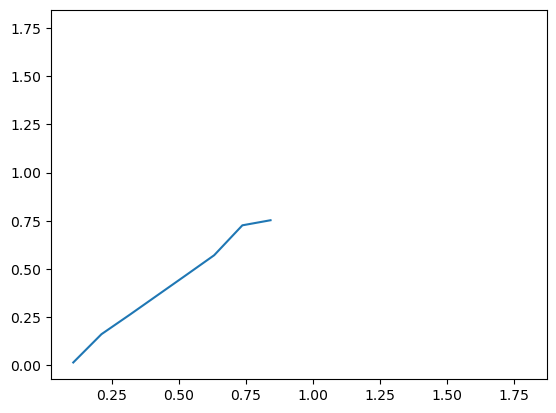

In [98]:
fig, ax = plt.subplots()
dh = np.abs(np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0))))
# print(dh.dtype)
# mask = dh<1.5
bins = np.linspace(0,2,num=20)
dig = np.digitize(dh,bins)

binned_F = np.array([dh[dig==a].mean() for a in range(20)])
ax.plot(bins, binned_F)

# ax.scatter(np.abs(dh[mask]),y_sm[:,:,mask].mean(axis=1))
# # ax.scatter(np.abs(dh),rho)

r,p = sp.stats.spearmanr(np.abs(dh[mask]), y_sm[:,:,mask].mean(axis=1).ravel())
# r,p = sp.stats.spearmanr(np.abs(dh), rho)
print(r,p)



In [21]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading, heading_bins)-1
occ = np.bincount(heading_dig)
occ = occ/occ.sum(keepdims=True)

weights = 1-occ
# print(weights)
offset_var = 0
heading_weights = np.zeros_like(heading)
for b in range(16):
    
    _mask = heading_dig==b
    heading_weights[_mask]=weights[b]
    offset_var += sp.stats.circvar(offset[_mask])
offset_var /= 16
# print(heading_weights)

y_ha_weighted = y_sm_heading_aligned[1,:,][:,mask]*heading_weights[np.newaxis,np.newaxis,mask]
fig, ax = plt.subplots()
ax.plot(y_ha_weighted.mean(axis=-1).ravel())
mu, sem = y_ha_weighted.mean(axis=-1).ravel(), sp.stats.sem(y_ha_weighted,axis=-1).ravel()
print(mu.shape, sem.shape)
ax.fill_between(np.arange(16), mu-sem, mu+sem)

y_sm_weighted = y_sm[1,:,:][:,mask]*heading_weights[np.newaxis,np.newaxis,mask]
mu, sem = y_sm_weighted.mean(axis=-1).ravel(), sp.stats.sem(y_sm_weighted,axis=-1).ravel()
print(mu.shape, sem.shape)
ax.fill_between(np.arange(16), mu-sem, mu+sem)

print(offset_var)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# print(sp.stats.circvar(offset[mask]))

In [21]:
y_autocorr = np.nan*np.zeros([1,y.shape[1]-1,y.shape[2]])
for t in range(y.shape[-1]):
    if mask[t]:
        
        data = y[0,:,t]


        # Calculate Pearson autocorrelation for different lags
        max_lag = data.shape[0] 
        y_autocorr[0,:,t] = [sp.stats.pearsonr(data, np.roll(data,i,axis=0))[0] for i in range(1,max_lag)]


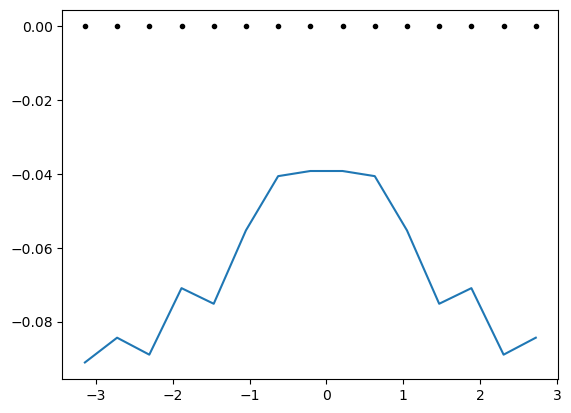

In [97]:
fig, ax = plt.subplots()
ax.plot(np.arange(-np.pi,np.pi,2*np.pi/15),np.roll(np.nanmean(y_autocorr[0,:,:], axis=-1),8))
ax.plot(np.arange(-np.pi,np.pi,2*np.pi/15), np.zeros([15,]),'k.')
# ax.imshow(y_autocorr[0,10:,], aspect='auto')